# Build the Model

In [36]:
import pandas as pd
import numpy as np
import json
import pickle
import spacy
from spacy.matcher import DependencyMatcher
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
nlp = spacy.load('en_core_web_lg')
matcher = DependencyMatcher(nlp.vocab)

In [13]:
# Open the pattern JSON file
with open("../data/patterns.json", "r") as file:
    patterns_dict = json.load(file)

# Add the patterns to the matcher
for pattern_name, pattern_list in patterns_dict.items():
    matcher.add(f'{pattern_name}', [pattern_list])

In [28]:
df = pd.read_csv('../data/PELIC_ASAG_balanced.csv').drop(['Unnamed: 0'],axis=1)

In [29]:
df.head()

,level,L1,question_type,question,answer,dataset,is_augmented
0,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",Can you give me a opinion about this matter?,PELIC,0
1,2,Chinese,Short answer,"Write a sentence with the word ""own"".",I own this car and this horse.,PELIC,0
2,2,Italian,Short answer,"Write a sentence with the word ""own"".",I own a car.,PELIC,0
3,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",I don't have opinion about that thing,PELIC,0
4,2,Korean,Short answer,"Write a sentence with the word ""opinion"".",The opinion is my ider. \n\nSometimes i think ...,PELIC,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   level          6999 non-null   int64 
 1   L1             6999 non-null   object
 2   question_type  6999 non-null   object
 3   question       6999 non-null   object
 4   answer         6999 non-null   object
 5   dataset        6999 non-null   object
 6   is_augmented   6999 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 382.9+ KB


In [27]:
# df = df.head(20).copy()

In [26]:
# # Define a function to count the patterns in the answers
# def count_patterns(text, matcher):
#     """Count the number of pattern matches in the text."""
#     doc = nlp(text)
#     matches = matcher(doc)
#     counts = {pattern_name: 0 for pattern_name in patterns_dict.keys()}
#     for match_id, token_ids in matches:
#         pattern_name = matcher.vocab.strings[match_id]
#         counts[pattern_name] += 1
#     return counts

# def find_patterns(df):
#     df = df.copy()
#     pattern_names = list(patterns_dict.keys())
#     for pattern_name in pattern_names:
#             df[pattern_name] = 0.0
    
#     for index, row in df.iterrows():
#         answer_text = row['answer']
#         doc = nlp(answer_text)
#         total_tokens = 0
#         num_sentences = 0

#         for sentence in doc.sents:
#             num_tokens = len(sentence)
#             total_tokens += num_tokens
#             num_sentences += 1

#         avg_sentence_len = total_tokens / num_sentences
#         df.loc[index, 'num_sentences'] = num_sentences
#         df.loc[index, 'avg_sentence_len'] = avg_sentence_len

#         pattern_counts = count_patterns(answer_text, matcher)
#         for pattern_name, count in pattern_counts.items():
#             df.at[index, pattern_name] = count / num_sentences

#     return df

In [25]:
# find_patterns(df)

In [31]:
def count_patterns(text, matcher):
    """Count the number of pattern matches in the text."""
    doc = nlp(text)
    matches = matcher(doc)
    counts = {pattern_name: 0 for pattern_name in patterns_dict.keys()}
    for match_id, token_ids in matches:
        pattern_name = matcher.vocab.strings[match_id]
        counts[pattern_name] += 1
    return counts

def preprocess_text(doc):
    """Remove stop words, lemmatize the text, and return the document vector."""
    # Remove stop words and lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    # Join the tokens back to a single string (if needed)
    preprocessed_text = ' '.join(tokens)
    # Return the document vector
    vector = doc.vector
    return preprocessed_text, vector

def find_patterns(df):
    df = df.copy()
    pattern_names = list(patterns_dict.keys())
    
    # Initialize columns for pattern counts as floats
    for pattern_name in pattern_names:
        df[pattern_name] = 0.0
    
    df['num_sentences'] = 0
    df['avg_sentence_len'] = 0.0
    df['preprocessed_text'] = ""
    df['doc_vector'] = None
    
    for index, row in df.iterrows():
        answer_text = row['answer']
        doc = nlp(answer_text)
        total_tokens = 0
        num_sentences = 0

        # First, count the sentences and calculate average sentence length
        for sentence in doc.sents:
            num_tokens = len(sentence)
            total_tokens += num_tokens
            num_sentences += 1

        avg_sentence_len = total_tokens / num_sentences if num_sentences > 0 else 0
        df.loc[index, 'num_sentences'] = num_sentences
        df.loc[index, 'avg_sentence_len'] = avg_sentence_len

        # Count patterns in the original text
        pattern_counts = count_patterns(answer_text, matcher)
        for pattern_name, count in pattern_counts.items():
            df.at[index, pattern_name] = count / num_sentences if num_sentences > 0 else 0
        
        # Then preprocess the text
        preprocessed_text, vector = preprocess_text(doc)
        df.at[index, 'preprocessed_text'] = preprocessed_text
        df.at[index, 'doc_vector'] = vector
    
    return df

In [32]:
result_df = find_patterns(df)
result_df

,level,L1,question_type,question,answer,dataset,is_augmented,present_simple_active,present_simple_active_aux,present_simple_active_modal,...,past_perfect_continuous_passive,will,would,gerund_subject,gerund_pcomp,gerund_xcomp,num_sentences,avg_sentence_len,preprocessed_text,doc_vector
0,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",Can you give me a opinion about this matter?,PELIC,0,0.000000,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1,10.000000,opinion matter ?,"[0.0011769056, 2.9805837, -5.421795, -1.281726..."
1,2,Chinese,Short answer,"Write a sentence with the word ""own"".",I own this car and this horse.,PELIC,0,1.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1,8.000000,car horse .,"[0.6177107, -0.139415, -5.1839, -3.4223375, 2...."
2,2,Italian,Short answer,"Write a sentence with the word ""own"".",I own a car.,PELIC,0,1.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1,5.000000,car .,"[-1.2149088, 0.9414881, -6.9475403, -3.24902, ..."
3,2,Chinese,Short answer,"Write a sentence with the word ""opinion"".",I don't have opinion about that thing,PELIC,0,0.000000,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1,8.000000,opinion thing,"[-0.66809255, 4.0117087, -4.705406, -2.6067538..."
4,2,Korean,Short answer,"Write a sentence with the word ""opinion"".",The opinion is my ider. \n\nSometimes i think ...,PELIC,0,1.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,2,7.000000,opinion ider . \n\n think matter .,"[0.741248, 0.15120213, -2.5288677, -2.9930537,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6994,5,French,Paragraph writing,Eating a balanced diet is the most important f...,"However, he or she is not the sum total of our...",ASAG,1,1.333333,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,3,16.666667,", sum total human animal part . part healthy h...","[-2.4230928, -0.373166, -3.4809585, -0.3138011..."
6995,5,German,Paragraph writing,Eating a balanced diet is the most important f...,The best way to find out is to look at your ow...,ASAG,1,0.928571,0.0,0.214286,...,0.0,0.0,0.0,0.0,0.000000,0.071429,14,15.571429,good way find look life . hear saying control ...,"[-0.4211187, 2.1125674, -3.934652, -1.2434685,..."
6996,5,French,Paragraph writing,Eating a balanced diet is the most important f...,"It is not something that can be fixed by diet,...",ASAG,1,1.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.666667,0.000000,3,18.666667,"fix diet , . fix drink water , smoke alcohol ,...","[-1.0024912, 1.3080591, -4.026916, -0.38865408..."
6997,5,French,Paragraph writing,Eating a balanced diet is the most important f...,Let me explain. \nI've been making salad for m...,ASAG,1,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,2,8.500000,let explain . \n make salad decade .,"[-1.3747396, 0.22705829, -3.1758237, -0.553739..."


In [34]:
result_df.to_csv('../data/PELIC_ASAG_balanced_matched_processed.csv')

In [35]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 42 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   level                                     6999 non-null   int64  
 1   L1                                        6999 non-null   object 
 2   question_type                             6999 non-null   object 
 3   question                                  6999 non-null   object 
 4   answer                                    6999 non-null   object 
 5   dataset                                   6999 non-null   object 
 6   is_augmented                              6999 non-null   int64  
 7   present_simple_active                     6999 non-null   float64
 8   present_simple_active_aux                 6999 non-null   float64
 9   present_simple_active_modal               6999 non-null   float64
 10  present_simple_passive              

In [59]:
result_df.columns

Index(['level', 'L1', 'question_type', 'question', 'answer', 'dataset',
       'is_augmented', 'present_simple_active', 'present_simple_active_aux',
       'present_simple_active_modal', 'present_simple_passive',
       'present_simple_passive_modal', 'present_continuous_active',
       'present_continuous_active_modal', 'present_continuous_passive',
       'present_continuous_passive_modal', 'present_perfect_active',
       'present_perfect_active_modal', 'present_perfect_passive',
       'present_perfect_passive_modal', 'present_perfect_continuous_active',
       'present_perfect_continuous_active_modal',
       'present_perfect_continuous_passive',
       'present_perfect_continuous_passive_modal', 'past_simple_active',
       'past_simple_active_aux', 'past_simple_passive',
       'past_continuous_active', 'past_continuous_passive',
       'past_perfect_active', 'past_perfect_passive',
       'past_perfect_continuous_active', 'past_perfect_continuous_passive',
       'will', 'would

In [60]:
verb_df = result_df[['present_simple_active', 'present_simple_active_aux',
       'present_simple_active_modal', 'present_simple_passive',
       'present_simple_passive_modal', 'present_continuous_active',
       'present_continuous_active_modal', 'present_continuous_passive',
       'present_continuous_passive_modal', 'present_perfect_active',
       'present_perfect_active_modal', 'present_perfect_passive',
       'present_perfect_passive_modal', 'present_perfect_continuous_active',
       'present_perfect_continuous_active_modal',
       'present_perfect_continuous_passive',
       'present_perfect_continuous_passive_modal', 'past_simple_active',
       'past_simple_active_aux', 'past_simple_passive',
       'past_continuous_active', 'past_continuous_passive',
       'past_perfect_active', 'past_perfect_passive',
       'past_perfect_continuous_active', 'past_perfect_continuous_passive',
       'will', 'would', 'gerund_subject', 'gerund_pcomp', 'gerund_xcomp']]

# Identify columns with only zeros
columns_with_only_zeros = [col for col in verb_df.columns if verb_df[col].nunique() == 1 and result_df[col].unique()[0] == 0]

# Print the columns
print("Columns with only zeros:", columns_with_only_zeros)

Columns with only zeros: ['present_continuous_passive_modal', 'present_perfect_continuous_passive_modal']


In [61]:
feature_columns = result_df.drop(columns=['level', 'L1', 'question_type', 'question', 'answer', 'dataset',
       'is_augmented', 'preprocessed_text', 'doc_vector','present_continuous_passive_modal', 'present_perfect_continuous_passive_modal']).columns
features = result_df[feature_columns].values
# Extract the document vectors and convert them to a suitable format
doc_vectors = np.stack(result_df['doc_vector'].values)
X = np.hstack((features, doc_vectors))
y = result_df['level']

In [62]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Initialize and train the classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

              precision    recall  f1-score   support

           2       0.75      0.90      0.82       373
           3       0.90      0.65      0.76       335
           4       0.72      0.72      0.72       349
           5       0.70      0.73      0.72       343

    accuracy                           0.76      1400
   macro avg       0.77      0.75      0.75      1400
weighted avg       0.77      0.76      0.75      1400

Confusion Matrix:
[[337   8   8  20]
 [ 49 218  38  30]
 [ 34   8 250  57]
 [ 31   7  53 252]]


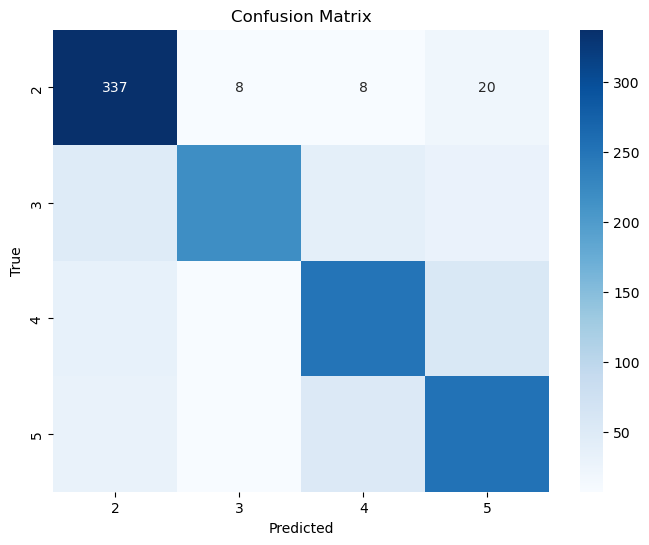

In [64]:
# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()